# Memories

Memories are of a complex behaviour, as there are many types to be detected and inferred. However, myhdl-yosys allows some more fine grained control to infer specific black boxes for architecture specific or abstract memory types.

See also [blackboxes](../../../blackbox.ipynb) for details on Blackbox inference and simulation.

A few memory type examples:

* [ROMs](#ROMs)
  1. [Single port ROM](#Single-port-ROM)
  +  Dual port ROM
* [RAMs](#RAMs)
  1. Single port read after write
  +  [Dual port RAM](#Dual-port-RAM)
  
First, we need to configure our environment:

In [1]:
import config

## ROMs

ROMs are normally detected by simply defining a global array containing constant values.

### Single port ROM

In [2]:
from random import randrange
from myhdl import *
from myhdl.conversion import yshelper

D = 8

ROM = tuple([randrange(D) for i in range(D)])

@block
def rom1(addr, dout, rom_data):
    "Asynchronous ROM inference"

    @always_comb
    def worker() :
        dout.next = rom_data[addr]

    return instances()

This works fine for small arrays, however for a large CPU ROM you may want to choose a Blackbox approach from the ROM library:

In [3]:
from synthesis.yosys import rom
rom1_bb = rom.Rom

## Synthesis

We synthesize the above construct:

In [4]:
from myhdl.conversion import yshelper as ys
import myhdl

# Set the UNIT (to test) variable:
UNIT = rom1
# Alternative:
# UNIT = rom1_bb

ce = Signal(bool())
dout, debug = [ Signal(intbv()[8:]) for i in range(2) ]

def convert(unit):
    # Declare the signals:    

    dout = Signal(intbv(0)[8:])
    addr = Signal(intbv(1)[8:])
    clk = Signal(bool(0))

    inst = unit(addr, dout, ROM)
    name = unit.func.__name__
    design = ys.Design(name)
    # Convert into synthesis RTLIL:
    # Make sure to set `trace` when you wish to look at a VCD file:
    inst.convert("yosys_module", design, name=name, trace=True)
    return design

design = convert(UNIT)
# Write out the verilog post-synthesis code for the cosimulation object (further below)
design.write_verilog(design.name, True)

Adding module with name: rom1_8_8_8
CONVERT_RTL tree >>>>>> 'ROM1_WORKER' 


### RTL display

We can see that two Blackboxes are inferred: One with an initialization value, and one read port. Note that the clk signal is left unwired, as we didn't use it. We can see that the initialization bit array can get quite large, therefore we have set the dimension of our ROM to `8x8` bits only.

Generating RTL image...
Display...


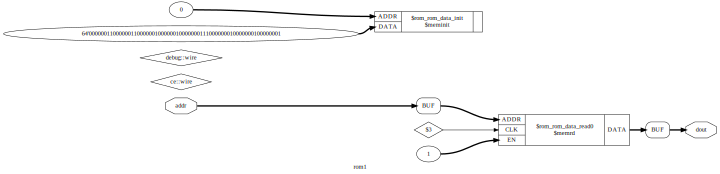

In [5]:
from ys_aux import to_svg

display(to_svg(design, "", 100))

### Exercise:

1. Create a test bench to verify correct ROM behaviour (copy from other notebooks)
+  Make use of the `clk` signal and turn the `rom1` unit into a clock synchronous design. You might rename it to `rom2`
   in the process.
+  Make a copy of the `rom1` test bench or modify it such that it can verify `rom1` and `rom2`.

### Synthesis test

The `$memrd` and `$meminit` primitives are intermediate port structures that can not yet be simulated.
The memories need to be collected into a true `$mem` primitive. This is done by the next command:

MODULES: {IdString "\rom1": Module "\rom1"}
TOP: Module "\rom1"
Generating RTL image...
Display...


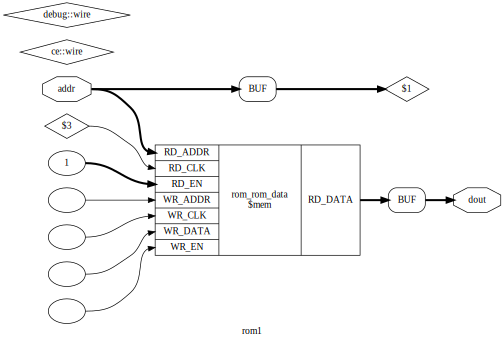

In [6]:
design.run("write_ilang rom.il")
m = design.design.top_module()
print("MODULES:", design.design.modules_)
print("TOP:", m)
#print(m.cache_mem)
#print(m.memories)
design.test_synth()
display(to_svg(design, "", 75))

## RAMs

### Single port RAM

**Omitted**

### Dual port RAM

As the RAM behaviour can get complex, we import one from the library.
For the RAM read/write ports, we use the provided `RAMport` class (which is also found in the ram library, but listed here for reference):

In [7]:
class RAMport:
    def __init__(self, awidth, dwidth):
        self.clk = Signal(bool(0))
        self.we = Signal(bool(0))
        self.ce = Signal(bool(0))
        self.addr = Signal(modbv()[awidth:])
        self.write = Signal(modbv()[dwidth:])
        self.read = Signal(modbv()[dwidth:])
        # Low/high select:
        self.sel = Signal(intbv()[2:])

We instantiate a Dual port RAM with one read, one write port with different addresses:

In [8]:
from synthesis.yosys import ram

def convert(unit):
    a, b = [ RAMport(8, 8) for i in range(2) ]

    dpram = unit(a, b, None, True)

    design = yshelper.Design("dpram")

    dpram.convert("yosys_module", design, name="dpram", trace=True)

    # design.display_dir()
    return design
ram_design = convert(ram.dpram_r1w1)


Legacy class a
Legacy class b
	Infer blackbox: 'dpram'
Legacy class a
Legacy class b
Adding module with name: dpram_r1w1_c1
Create yosys implementation of module


### RTL display

We note that two separate black boxes are created : a `$memwr` and a `$memrd` cell. They share a memory identifier `MEM_ID` internal parameter (invisible in the RTL display). Later at mapping stage, the synthesis algorithm will attempt to map those memory ports into a hardware entity.

The current yosys abstraction separates these hardware ports into a read and write port each. Therefore, a single port RAM will also create one read and write port per actual hardware port.

Generating RTL image...
Display...


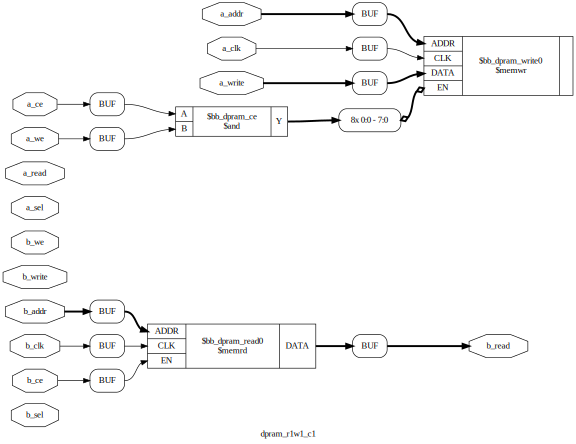

In [9]:
display(to_svg(ram_design, "", 80))

### Testing the RAM

We define the test bench as follows:

In [10]:
from random import randrange, seed
from ys_aux import setupCosimulation

def unroll_classmembers(c, name, args):
    for n, i in c.__dict__.items():
        mangled = "%s_%s" % (name, n)
        args[mangled] = i

@block
def tb_memory(memory, unitname):

    ports = [ RAMport(8, 8) for i in range(4) ]
    clk = Signal(bool(0))
    
    @block
    def dpram_mapped(unitname, a, b, HEXFILE = None, USE_CE = False):
        "Wrapper for cosimulation object"
        args = locals()
        name = unitname + "_mapped"
        unroll_classmembers(a, "a", args)
        unroll_classmembers(b, "b", args)
        args.pop("a")
        args.pop("b")
        args.pop("unitname")
        return setupCosimulation(name, use_assert=False, interface=args, debug=False)
  
    # First the known MyHDL model:
    ram_inst = memory(ports[0], ports[2], None, True)
    # Then the synthesized black box model:
    ram_inst_uut = dpram_mapped(unitname, ports[1], ports[3], None, True)

    @instance
    def stimulus():
        for p in ports:
            p.ce.next = True
        seed(20)

        for i in range(256):
            v = randrange(0, 256)

            for p in ports[:2]:
                p.addr.next = i
                p.write.next = v
                
            yield clk.negedge
            for p in ports[:2]:      
                p.we.next = True
                
            yield clk.posedge

            yield clk.negedge

            for p in ports[:2]:      
                p.we.next = False
 
            for p in ports[2:]:      
                p.addr.next = i
 

            yield clk.posedge
            yield clk.negedge

#            print("VALUES[%d]" % (i), ports[2].read, ports[3].read)
            if __debug__:
                if ports[2].read != ports[3].read:
                    for i in range(3):
                        yield clk.posedge

                    raise ValueError("Simulation mismatch")
        
        print("Verification successful")
        raise StopSimulation()

    @always_comb
    def assign():
        for p in ports:      
            p.clk.next = clk
        
    @instance
    def clkgen():
        clk.next = 1
        while 1:
            yield delay(10)
            clk.next = not clk

    return instances()


### Mapping and Cosimulation Output

We run a test synthesis script and write out Verilog:

In [11]:
ram_design.test_synth()
ram_design.write_verilog(ram_design.name, True)

Now we should have these Verilog output files ready for cosimulation:

In [12]:
!ls -l dpram_mapped.v tb_dpram_mapped.v

-rw-r--r-- 1 pyosys users 1124 Mar 21 22:23 dpram_mapped.v
-rw-r--r-- 1 pyosys users  974 Mar 21 22:23 tb_dpram_mapped.v


In [13]:
tb = tb_memory(ram.dpram_r1w1, ram_design.name)
tb.config_sim(backend = 'myhdl', timescale="1ps", trace=True)
tb.run_sim()
tb.quit_sim()

Writing to  00
Writing to  01
Writing to  02
Writing to  03
Writing to  04
Writing to  05
Writing to  06
Writing to  07
Writing to  08
Writing to  09
Writing to  0a
Writing to  0b
Writing to  0c
Writing to  0d
Writing to  0e
Writing to  0f
Writing to  10
Writing to  11
Writing to  12
Writing to  13
Writing to  14
Writing to  15
Writing to  16
Writing to  17
Writing to  18
Writing to  19
Writing to  1a
Writing to  1b
Writing to  1c
Writing to  1d
Writing to  1e
Writing to  1f
Writing to  20
Writing to  21
Writing to  22
Writing to  23
Writing to  24
Writing to  25
Writing to  26
Writing to  27
Writing to  28
Writing to  29
Writing to  2a
Writing to  2b
Writing to  2c
Writing to  2d
Writing to  2e
Writing to  2f
Writing to  30
Writing to  31
Writing to  32
Writing to  33
Writing to  34
Writing to  35
Writing to  36
Writing to  37
Writing to  38
Writing to  39
Writing to  3a
Writing to  3b
Writing to  3c
Writing to  3d
Writing to  3e
Writing to  3f
Writing to  40
Writing to  41
Writing to